# 使用Statannotations在seaborn图表上显示统计显著性

- 教程地址：https://www.schaetz.cz/MB100T01/Statistics/06_Statannotations-Tutorial-1.html

- 数据文件地址：https://github.com/trevismd/statannotations-tutorials

## 引言

在Python中，有许多库可用于数据清洗、分析和可视化绘图。Python还拥有功能强大的统计包，这些统计包被数千个其他项目所采用。仅在Github平台上，目前`statsmodels`就被用于超过44,000个开源项目，而`scipy`的应用项目数量更是超过350,000个（当然，并非所有项目都使用`scipy.stats`模块）。

尽管如此，若你希望像使用R语言或其他统计软件绘制学术论文中的图表那样，在图表上添加p值以及美观的显著性标注括号，可用的工具选择并不多。

在本教程中，我们将介绍`statannotations`包（版本v0.4.1），该包可用于在seaborn分类图表上添加统计显著性标注。

我们将首先配置所需的工具，然后说明本教程中将要使用的数据集。之后，我们将学习如何将如下所示的图表：  
![未添加标注的图表](./example_hue_layout_no_annot.png)  

优化为如下所示的带统计显著性标注的图表 ↓！  
![添加标注的图表](./example_hue_layout.png)  

具体而言，在演示如何安装并导入`statannotations`包之后，我们将解答以下问题：
- 如何为seaborn图表添加自定义标注？
- 如何以多种不同方式自动格式化先前计算得到的p值，并通过单次函数调用将这些p值添加至图表中？
- 如何同时执行统计检验并将检验结果添加至图表，且可选择应用多重比较校正方法？

后续教程将涵盖更高级的功能，例如与其他统计检验方法的对接、多种多重比较校正方法，以及对各类格式化选项的详细解析。

# 免责声明（DISCLAIMER）
本教程旨在说明**如何使用绘图标注库**，而非教授统计学知识。教程中的示例仅用于演示图表绘制方法，不代表统计学方法论的规范应用，且我们不会对所分析的数据集得出任何结论。

在统计学研究的正确实践中，应首先严谨界定研究问题，最终可能还需设计不同的组间比较方案和/或检验方法。当然，p值也并非适用于所有统计问题的“万能答案”，相关统计学原理与规范可参考其他专业资料。

## 准备工具（PREPARING THE TOOLS）

首先，我们需准备所需工具，即`pandas`、`numpy`、`pyplot`、`scipy`，当然还包括`seaborn`，此外还需若干辅助函数。

##### 导入

In [32]:
# 导入matplotlib库的pyplot模块，用于绘制各类可视化图表（如折线图、柱状图等）
import matplotlib.pyplot as plt
# 导入pandas库并简写为pd，用于数据读取、清洗、结构化处理（如DataFrame操作）
import pandas as pd
# 导入seaborn库并简写为sns，基于matplotlib的高级可视化库，擅长绘制统计类图表（如箱线图、小提琴图）
import seaborn as sns

# 导入自定义工具模块utils中的所有函数（用于提供教程所需的辅助性操作，如数据预处理、图表基础配置等）
from utils import *


# 导入numpy库并简写为np，用于数值计算（如数组运算、统计量计算等）
import numpy as np
# 从scipy.stats模块导入统计检验函数：
# mannwhitneyu：Mann-Whitney U检验（非参数检验，用于比较两组独立样本的分布差异）
# normaltest：正态性检验（用于判断数据是否符合正态分布）
from scipy.stats import mannwhitneyu, normaltest

在`utils`模块中，实现了以下两类函数，分别用于数据信息打印与绘图流程简化：


## 1. 格式化打印函数（Pretty-print）
该类函数用于以清晰、可读的格式输出数据集关键信息，便于快速了解数据基本特征：
- `print_n_projects`：
  打印输入数据集中包含的项目总数。
- `describe_array`：
  打印一维数组（1D-array）的多项统计指标（如均值、标准差、中位数、最值等）。
- `print_projects_by`：
  按“子类别（Subcategory）”分组，基于指定函数（`func`）的计算结果对项目列表进行排序后打印。


## 2. 绘图重复操作简化函数
该类函数用于封装绘图流程中重复出现的配置步骤（如坐标轴设置、标签添加等），减少代码冗余：
- `get_log_ax`：
  创建一个新的`pyplot`图形对象（figure），为其设置对数刻度（logarithmic scale）与不透明背景（opaque background），最终返回坐标轴对象（`ax`）。
- `label_plot_for_subcats`：
  为以“子类别（Subcategory）”作为x轴坐标的图表，添加标题（title）与坐标轴标签（axes labels）。
- `label_plot_for_states`：
  为以“状态（State）”作为x轴坐标的图表，添加标题（title）与坐标轴标签（axes labels）。
- `add_legend`：
  为图表添加图例（legend），用于区分不同数据系列的含义。

## 准备数据（Preparing the data）

本教程将使用Kickstarter数据集，该数据集包含2009–2017年期间375,000余个Kickstarter项目相关数据，具体涵盖374,853条项目活动记录。该数据集可从以下链接下载：https://www.mavenanalytics.io/data-playground

In [35]:
# 使用pandas的read_csv函数读取Kickstarter项目数据集
# 数据文件路径为上级目录下的"kickstarter_projects.csv"文件（../表示向上一级目录）
dataset = pd.read_csv('../kickstarter_projects.csv')

# 调用DataFrame的head()方法，默认显示数据集前5行数据
# 用于快速查看数据的结构、列名及前几条记录的内容，初步判断数据格式是否符合预期
dataset.head()

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State
0,1860890148,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,Failed
1,709707365,CRYSTAL ANTLERS UNTITLED MOVIE,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,Failed
2,1703704063,drawing for dollars,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,35,3,Successful
3,727286,Offline Wikipedia iPhone app,Technology,Software,United States,2009-04-25 17:36:21,2009-07-14,99,145,25,Successful
4,1622952265,Pantshirts,Fashion,Fashion,United States,2009-04-27 14:10:39,2009-05-26,1900,387,10,Failed


活动可划分为以下类别：

In [ ]:
# 查看数据集中"Category"（类别）字段的所有唯一值（即去重后的所有类别）
# 用途：常用于数据探索阶段，快速了解分类变量的取值范围，排查类别数量、异常值或拼写不一致问题
# 示例：若dataset为营销活动数据集，执行后可能返回类似["品牌推广", "用户留存", "市场拓展"]的列表
list(dataset.Category.unique())

我喜欢科技，让我们看看这里有什么

##### 探索科技类别（Exploring the Technology category）

In [43]:
tech = dataset.loc[(dataset.Category=='Technology'), :]
print_n_projects(tech, 'Technology')
print_projects_by(tech, 'ID', 'count')

There are 32562 projects in Technology.
1. Technology           6.93e+03
2. Apps                 6.34e+03
3. Web                  3.91e+03
4. Hardware             3.66e+03
5. Software             3.05e+03
6. Gadgets              2.96e+03
7. Wearables            1.23e+03
8. DIY Electronics      9.02e+02
9. 3D Printing          6.82e+02
10. Sound               6.69e+02
11. Robots              5.72e+02
12. Flight              4.26e+02
13. Camera Equipment    4.16e+02
14. Space Exploration   3.23e+02
15. Fabrication Tools   2.50e+02
16. Makerspaces         2.38e+02


`技术（Technology）`类别下共有超过30,000个项目。其中规模最大的子类别同样命名为`技术（Technology）`，该子类别下已注册的项目数量接近7,000个；而规模最小的子类别为`创客空间（Makerspaces）`，其注册项目数量仅为238个。

接下来，我们对`目标金额（Goal）`列的数据进行分析。该列数据代表各众筹活动的融资目标，其货币单位为美元（USD）。

##### 按“子类别”划分的总目标金额

In [8]:
# List of tech subcategories, sorted by sum of project Goals
print_projects_by(tech, "Goal", "sum")

1. Technology           1.11e+09
2. Apps                 4.49e+08
3. Web                  4.00e+08
4. Hardware             3.43e+08
5. Software             2.85e+08
6. Space Exploration    1.86e+08
7. Gadgets              1.55e+08
8. Robots               1.07e+08
9. Wearables            7.47e+07
10. Flight              5.93e+07
11. 3D Printing         3.18e+07
12. Sound               3.12e+07
13. Makerspaces         3.11e+07
14. Fabrication Tools   2.90e+07
15. DIY Electronics     1.81e+07
16. Camera Equipment    1.66e+07


从数据中可观察到，就**项目总数**而言，`Sound`（声音技术）、`Robots`（机器人技术）与`Flight`（飞行技术）三个子类别的排名依次为第10位、第11位与第12位；而若以**总目标金额**为统计维度，三者的排名顺序发生显著变化，具体表现为：
- `Robots`（机器人技术）：排名上升至第8位，较项目总数排名提升3位；
- `Flight`（飞行技术）：排名上升至第10位，较项目总数排名提升2位；
- `Sound`（声音技术）：排名维持第12位，较项目总数排名下降2位。

#### 仔细看看这些类别：`机器人`、`飞行`、`声音`
为简化后续分析流程，我们将原始数据集的一个子集定义为新的 DataFrame（数据框），并命名为 **`rfs`**。该子集的筛选规则为：仅保留原始数据集中隶属于前述三个子类别（即`Sound`、`Robots`、`Flight`）的所有行数据，剔除其他子类别数据以聚焦核心分析对象。

In [9]:
rfs = tech.loc[(tech.Subcategory.isin(("Robots", "Flight", "Sound"))), :]

print_n_projects(rfs, "rfs")

There are 1667 projects in rfs.


让我们为子类别和状态图表定义颜色和排序方式

In [10]:
subcat_palette = sns.dark_palette("#8BF", reverse=True, n_colors=5)
states_palette = sns.color_palette("YlGnBu", n_colors=5)

states_order = ["Successful", "Failed", "Live", "Suspended", "Canceled"]
subcat_order = ['Robots', 'Flight', 'Sound']

#### 图1（PLOT 1）

C:\Users\ASUS\AppData\Local\Temp\ipykernel_48472\732638209.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, data=rfs, x='Subcategory', y='Goal', palette=subcat_palette,
C:\Users\ASUS\AppData\Local\Temp\ipykernel_48472\732638209.py:5: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.boxplot(ax=ax, data=rfs, x='Subcategory', y='Goal', palette=subcat_palette,


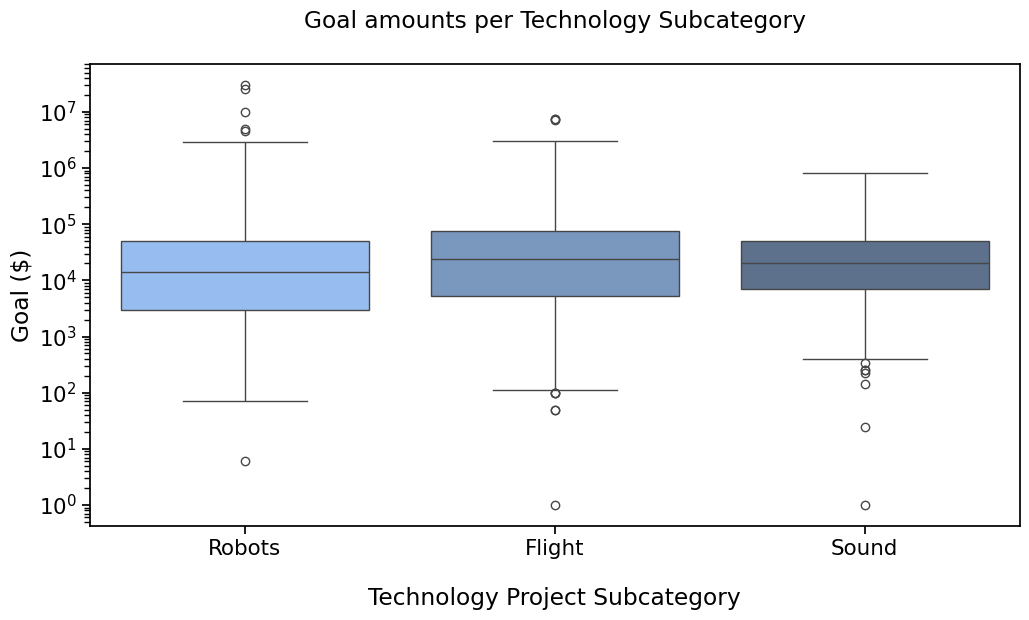

In [11]:
with sns.plotting_context("notebook", font_scale=1.4):
    # Create new plot
    ax = get_log_ax()

    sns.boxplot(ax=ax, data=rfs, x='Subcategory', y='Goal', palette=subcat_palette,
                order=subcat_order)

    label_plot_for_subcats(ax)
    plt.savefig("plot1.png", bbox_inches='tight')

#### 图2（PLOT 2）

C:\Users\ASUS\AppData\Local\Temp\ipykernel_48472\640777738.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, data=rfs, x='State', y='Goal', palette=states_palette,


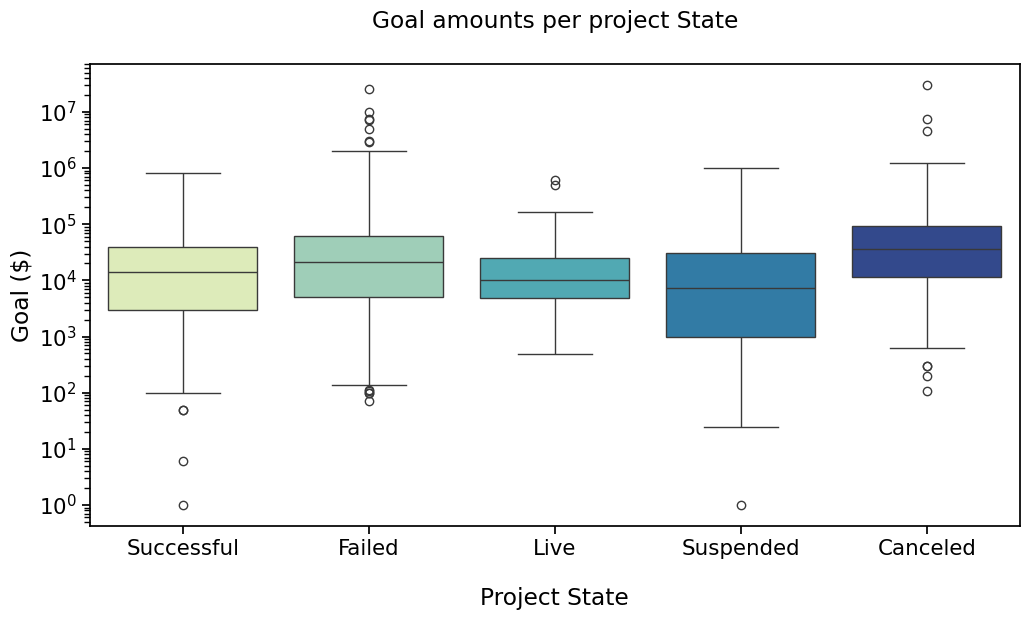

In [12]:
with sns.plotting_context("notebook", font_scale=1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    sns.boxplot(ax=ax, data=rfs, x='State', y='Goal', palette=states_palette,
                order=states_order)

    label_plot_for_states(ax)
    plt.savefig("./plot2.png", bbox_inches='tight')


#### 那么，这些数值在`统计上`是不同的吗？

### 为`scipy`准备数组

###### 按“子类别”

In [13]:
robots = rfs.loc[(rfs.Subcategory == "Robots"), "Goal"].values
flight = rfs.loc[(rfs.Subcategory == "Flight"), "Goal"].values
sound = rfs.loc[(rfs.Subcategory == "Sound"), "Goal"].values

log_robots = np.log(robots)
log_flight = np.log(flight)
log_sound = np.log(sound)

describe_array(robots, "Robots")
describe_array(flight, "Flight")
describe_array(sound, "Sound")
print()
describe_array(log_robots, "Log(Robots)")
describe_array(log_flight, "Log(Flight)")
describe_array(log_sound, "Log(Sound)")

"Robots"       Number of projects: 572	Min: 6.00	Max: 3.00e+07	Avg: 187211.62	Median: 1.43e+04
"Flight"       Number of projects: 426	Min: 1.00	Max: 7.50e+06	Avg: 139219.90	Median: 2.40e+04
"Sound"        Number of projects: 669	Min: 1.00	Max: 8.00e+05	Avg: 46710.19	Median: 2.00e+04

"Log(Robots)"  Number of projects: 572	Min: 1.79	Max: 1.72e+01	Avg: 9.42	Median: 9.57e+00
"Log(Flight)"  Number of projects: 426	Min: 0.00	Max: 1.58e+01	Avg: 9.87	Median: 1.01e+01
"Log(Sound)"   Number of projects: 669	Min: 0.00	Max: 1.36e+01	Avg: 9.79	Median: 9.90e+00


#### 检验正态性（Test normality）

In [11]:
print("Robots: ", normaltest(robots).pvalue)
print("Flight: ", normaltest(flight).pvalue)
print("Sound: ", normaltest(sound).pvalue)
print()
print("Log(robots): ", normaltest(log_robots).pvalue)
print("Log(Flight): ", normaltest(log_flight).pvalue)
print("Log(Sound): ", normaltest(log_sound).pvalue)

Robots:  7.130273714967154e-254
Flight:  2.2950178743850582e-154
Sound:  8.976320746933668e-155

Log(robots):  0.058274531619200785
Log(Flight):  1.9621087718193705e-06
Log(Sound):  8.503743627935909e-22


那基本上不行，我们来应用曼-惠特尼U检验吧

In [14]:
# pvalues with scipy:
stat_results = [mannwhitneyu(robots, flight, alternative="two-sided"),
                mannwhitneyu(flight, sound, alternative="two-sided"),
                mannwhitneyu(robots, sound, alternative="two-sided")]

print("Robots vs Flight: ", stat_results[0])
print("Flight vs Sound: ", stat_results[1])
print("robots vs Sound: ", stat_results[2])

pvalues = [result.pvalue for result in stat_results]

Robots vs Flight:  MannwhitneyuResult(statistic=np.float64(104646.0), pvalue=np.float64(0.00013485140468088997))
Flight vs Sound:  MannwhitneyuResult(statistic=np.float64(148294.5), pvalue=np.float64(0.2557331102364572))
robots vs Sound:  MannwhitneyuResult(statistic=np.float64(168156.0), pvalue=np.float64(0.00022985464929005115))


Remember the first plot
![plot1](./plot1.png)

如何在图表上添加统计显著性（p值）？
目前有几种可实现的方案，但均需编写较多代码。若你主动搜索，可找到这些方案。

不过，本部分将为你介绍 `statannotations` 工具（以替代上述方案）。

## 什么是Statannotations？

`Statannotations` 是一个[开源](https://github.com/trevismd/statannotations)包，能够支持用户在 `seaborn` 分类图表（包括 `barplot`（条形图）、`boxplot`（箱线图）、`stripplot`（散点图）、`swarmplot`（蜂群图）和 `violinplot`（小提琴图））上添加统计显著性标注。

该包基于 [`statannot`](https://github.com/webermarcolivier/statannot) 开发，但目前提供了不同的应用程序编程接口（API）。

### 安装

若需安装 `statannotations`，可使用 `pip` 工具，执行以下命令：

    pip install statannotations


此外，若需在本教程后续内容中使用多重比较校正（multiple comparisons correction）功能，还需额外安装 `statsmodels`，执行以下命令：

    pip install statsmodels

###### Importing the main class

In [44]:
from statannotations.Annotator import Annotator

## 使用statannotations

通用流程
0. 确定您想要添加标注的数据对（pairs of data）

1. 实例化（Instantiate）一个`Annotator`对象（或在新图表中复用该对象，后续将对此进行介绍）

2. 配置该对象（包括文本格式（text formatting）、统计检验（statistical test）、多重比较校正方法（multiple comparisons correction method）等）

3. 生成标注内容（后续将介绍以下场景）
    - 通过提供完全自定义的标注内容实现（场景A）
    - 通过提供需先格式化再添加至图表的p值实现（场景B）
    - 通过应用已配置的检验实现（场景C）

4. 执行标注（Annotate !）

### A - 添加任何文本，例如之前计算的结果

若已创建 seaborn 图表（及其关联的 `ax` 对象），且拥有统计结果或其他需在图表上显示的文本，需遵循以下详细步骤。

**步骤 0（STEP 0）：确定比较对象**
为图表添加注释的前提条件是，明确需进行比较的组别对。  
需在 `pairs` 参数中指定想要添加注释的箱体（或柱形、小提琴形等）组别。本场景下，该参数的作用等同于指定“机器人组（Robots）vs 飞行组（Flight）”等比较关系。  

对于统计注释，需将比较组别对以元组列表的形式指定，例如 `('Robots', 'Flight')`，具体代码如下：

```python
pairs = [('Robots', 'Flight'),  # “机器人组（Robots）”与“飞行组（Flight）”比较
             ('Flight', 'Sound'),   # “飞行组（Flight）”与“声音组（Sound）”比较
             ('Robots', 'Sound')]   # “机器人组（Robots）”与“声音组（Sound）”比较
```

**步骤 1（STEP 1）：创建注释器（Annotator）**
此时已具备实例化注释器所需的全部要素，具体代码如下：

```python
annotator = Annotator(ax, pairs, ...)  # 其中 ... 代表传递给 seaborn 绘图函数的所有参数
```

**步骤 2（STEP 2）：本示例中不进行任何配置**

**步骤 3（STEP 3）：添加来自 scipy 的原始 p 值**
首先通过以下代码获取 scipy 计算得到的原始 p 值：
```python
pvalues = [sci_stats.mannwhitneyu(robots, flight, alternative="two-sided").pvalue,
           sci_stats.mannwhitneyu(flight, sound, alternative="two-sided").pvalue,
           sci_stats.mannwhitneyu(robots, sound, alternative="two-sided").pvalue]
```

随后使用以下代码将 p 值添加至注释器：
```python
annotator.set_custom_annotations(pvalues)
```

**步骤 4（STEP 4）：执行注释操作**
```python
annotator.annotate()
```

> （*）注意：需确保 `pairs` 列表与注释内容（本例中为 p 值）的顺序保持一致。

C:\Users\ASUS\AppData\Local\Temp\ipykernel_48472\2888470630.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(**plotting_parameters)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_48472\2888470630.py:22: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.boxplot(**plotting_parameters)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Robots vs. Flight: p=1.35e-04
Flight vs. Sound: p=2.56e-01
Robots vs. Sound: p=2.30e-04


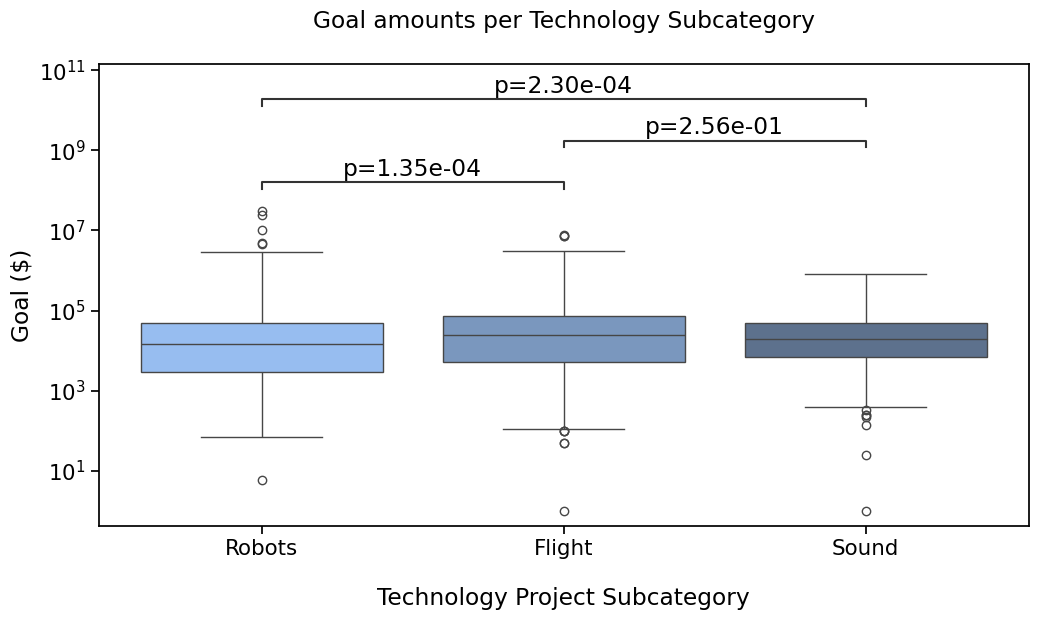

In [17]:
# Putting the parameters in a dictionary avoids code duplication
# since we use the same for `sns.boxplot` and `Annotator` calls
plotting_parameters = {
    'data':    rfs,
    'x':       'Subcategory',
    'y':       'Goal',
    'order':   subcat_order,
    'palette': subcat_palette,
}

pairs = [('Robots', 'Flight'),
         ('Flight', 'Sound'),
         ('Robots', 'Sound')]

formatted_pvalues = [f"p={p:.2e}" for p in pvalues]

with sns.plotting_context('notebook', font_scale=1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    sns.boxplot(**plotting_parameters)

    # Add annotations
    annotator = Annotator(ax, pairs, **plotting_parameters)
    annotator.set_custom_annotations(formatted_pvalues)
    annotator.annotate()

    # Label and show
    label_plot_for_subcats(ax)
    plt.savefig("./plot1A.png", bbox_inches='tight')
    plt.show()


### B - 让我们自动格式化这些p值，以获得更美观的结果

我们将使用`set_pvalues`而非`set_custom_annotations`，以利用其格式设置选项。

#### 使用星号标记（默认）

C:\Users\ASUS\AppData\Local\Temp\ipykernel_48472\3368377619.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, **plotting_parameters)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_48472\3368377619.py:6: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.boxplot(ax=ax, **plotting_parameters)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Robots vs. Flight: Custom statistical test, P_val:1.349e-04
Flight vs. Sound: Custom statistical test, P_val:2.557e-01
Robots vs. Sound: Custom statistical test, P_val:2.299e-04


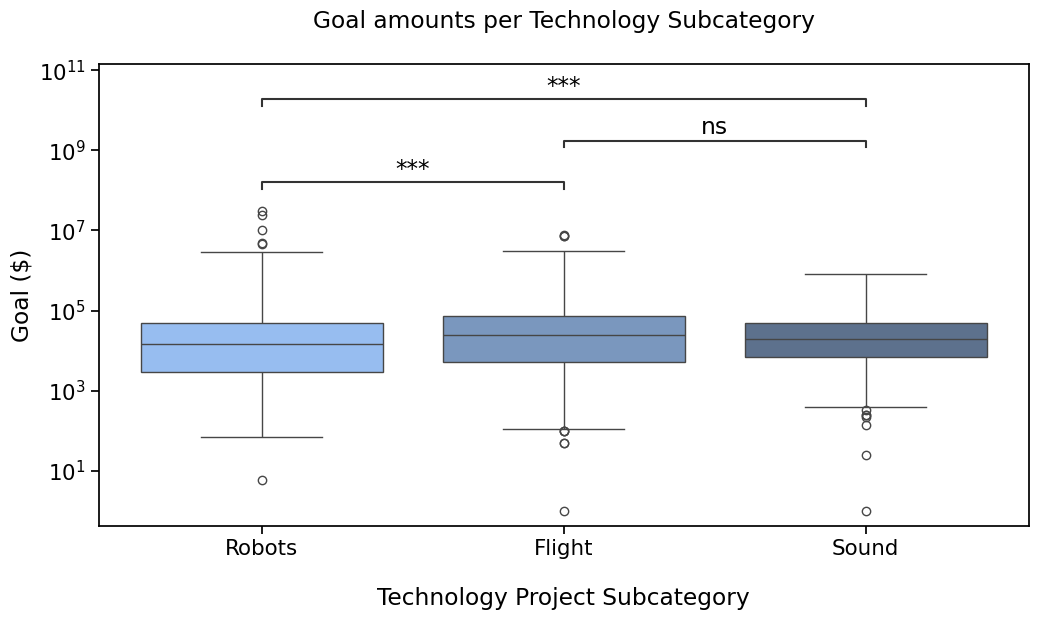

In [18]:
with sns.plotting_context("notebook", font_scale=1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    sns.boxplot(ax=ax, **plotting_parameters)

    # Add annotations
    annotator = Annotator(ax, pairs, **plotting_parameters)
    annotator.set_pvalues(pvalues)
    annotator.annotate()

    # Label and show
    label_plot_for_subcats(ax)
    plt.show()

#### 采用简单的格式来显示重要性

在这种情况下，我们将把`text_format`配置为`simple`，以显示p值的摘要。

C:\Users\ASUS\AppData\Local\Temp\ipykernel_48472\2277695771.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, **plotting_parameters)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_48472\2277695771.py:6: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.boxplot(ax=ax, **plotting_parameters)


Robots vs. Flight: Custom statistical test, P_val:1.349e-04
Flight vs. Sound: Custom statistical test, P_val:2.557e-01
Robots vs. Sound: Custom statistical test, P_val:2.299e-04


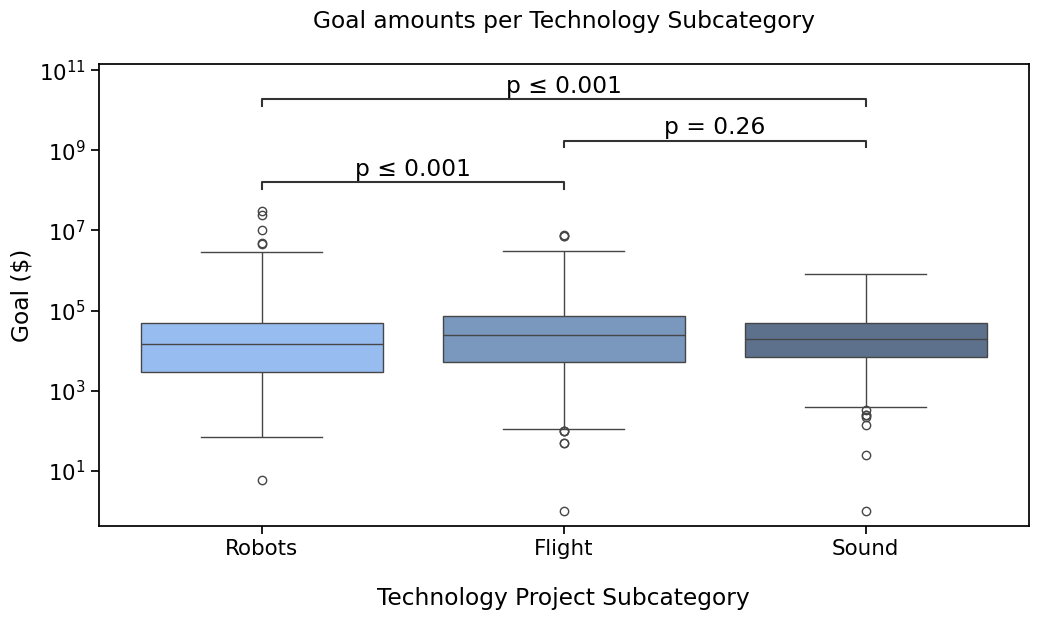

In [19]:
with sns.plotting_context("notebook", font_scale=1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    sns.boxplot(ax=ax, **plotting_parameters)

    # Add annotations
    annotator = Annotator(ax, pairs, **plotting_parameters)
    annotator.configure(text_format="simple")
    annotator.set_pvalues(pvalues).annotate()

    # Label and show
    label_plot_for_subcats(ax)
    plt.show()

我们还可以提供一个`test_short_name`参数，使其显示在p值的正前方。

我还会展示如何通过重用注释器实例来进一步减少所需的代码，因为我们不会更改数据和配对。这也会记住我们配置的`text_format`选项。

C:\Users\ASUS\AppData\Local\Temp\ipykernel_48472\1641235997.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, **plotting_parameters)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_48472\1641235997.py:6: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.boxplot(ax=ax, **plotting_parameters)


Robots vs. Flight: Custom statistical test, P_val:1.349e-04
Flight vs. Sound: Custom statistical test, P_val:2.557e-01
Robots vs. Sound: Custom statistical test, P_val:2.299e-04


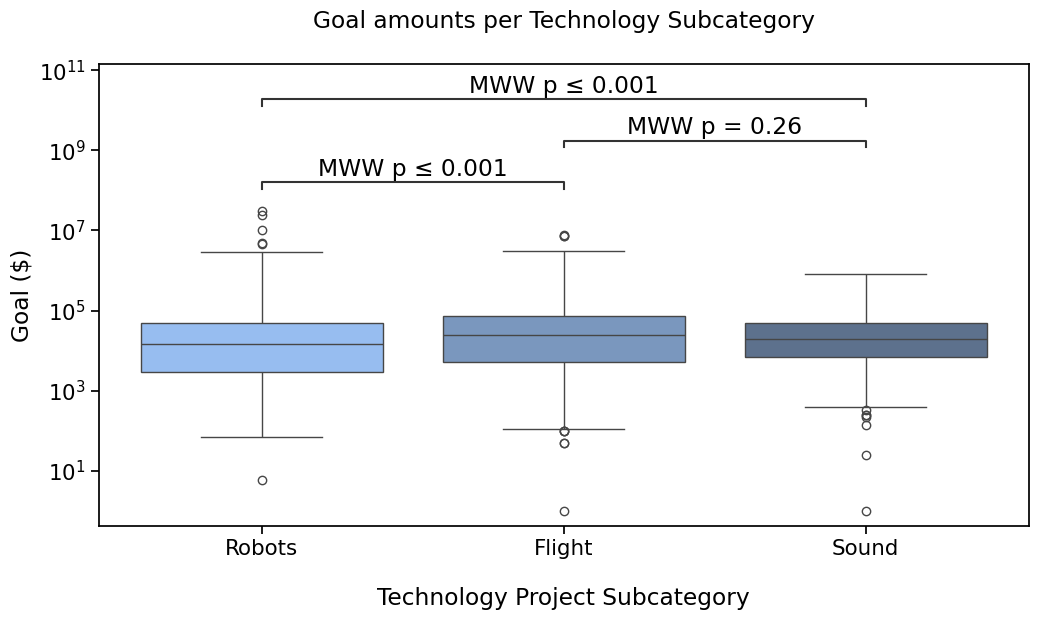

In [20]:
with sns.plotting_context("notebook", font_scale=1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    sns.boxplot(ax=ax, **plotting_parameters)

    # Add annotations
    annotator.new_plot(ax, **plotting_parameters)  # Same pairs and data, we can keep the annotator
    annotator.configure(test_short_name="MWW")     # text_format is still simple
    annotator.set_pvalues_and_annotate(pvalues)    # in one function call

    # Label and show
    label_plot_for_subcats(ax)
    plt.show()

#### 调整布局

我希望注释和文本之间有更多的间距。

`annotate`方法允许通过参数来实现这一点。

C:\Users\ASUS\AppData\Local\Temp\ipykernel_48472\3128612538.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, **plotting_parameters)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_48472\3128612538.py:6: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.boxplot(ax=ax, **plotting_parameters)


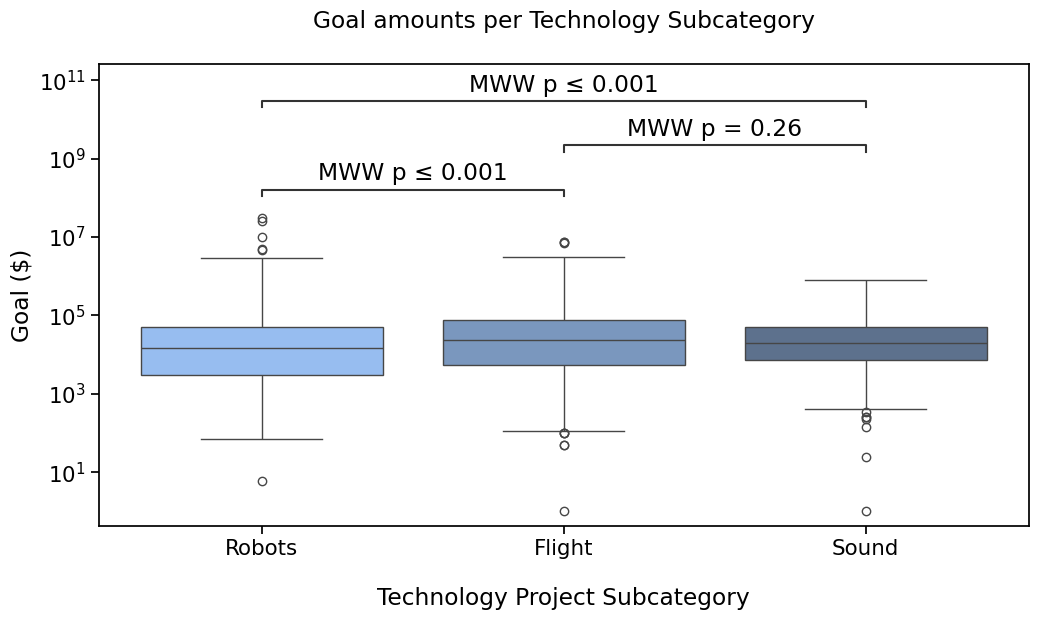

In [21]:
with sns.plotting_context("notebook", font_scale=1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    sns.boxplot(ax=ax, **plotting_parameters)

    # Add annotations
    annotator.new_plot(ax, **plotting_parameters)    # Same pairs and data, we can keep the annotator
    annotator.configure(text_offset=3, verbose=0)  # Disabling printed output as it is the same
    annotator.set_pvalues(pvalues)                   # Now, test_short_name is also remembered
    annotator.annotate()

    # Label and show
    label_plot_for_subcats(ax)
    plt.show()

### 使用statannotations来应用scipy测试

最后，通过直接调用 `scipy.stats`，`statannotations` 库能够完成假设检验所需的大部分步骤，并对图表进行标注。

该库支持的检验方法选项如下：
- 曼-惠特尼检验（Mann-Whitney test）
- t检验（包括独立样本t检验和配对样本t检验，t-test (independent and paired)）
- 韦尔奇t检验（Welch's t-test）
- 莱文检验（Levene test）
- 威尔科克森检验（Wilcoxon test）
- 克鲁斯卡尔-沃利斯检验（Kruskal-Wallis test）

在接下来的教程中，我将介绍如何使用一种未被 `statannotations` 库直接集成的检验方法。

若您感兴趣，也可查看该项目仓库中的使用示例笔记本（notebook），链接如下：[https://github.com/trevismd/statannotations/blob/master/usage/example.ipynb](https://github.com/trevismd/statannotations/blob/master/usage/example.ipynb)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_48472\2846712805.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, **plotting_parameters)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_48472\2846712805.py:6: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.boxplot(ax=ax, **plotting_parameters)


Robots vs. Flight: Mann-Whitney-Wilcoxon test two-sided, P_val:1.349e-04 U_stat=1.046e+05
Flight vs. Sound: Mann-Whitney-Wilcoxon test two-sided, P_val:2.557e-01 U_stat=1.483e+05
Robots vs. Sound: Mann-Whitney-Wilcoxon test two-sided, P_val:2.299e-04 U_stat=1.682e+05


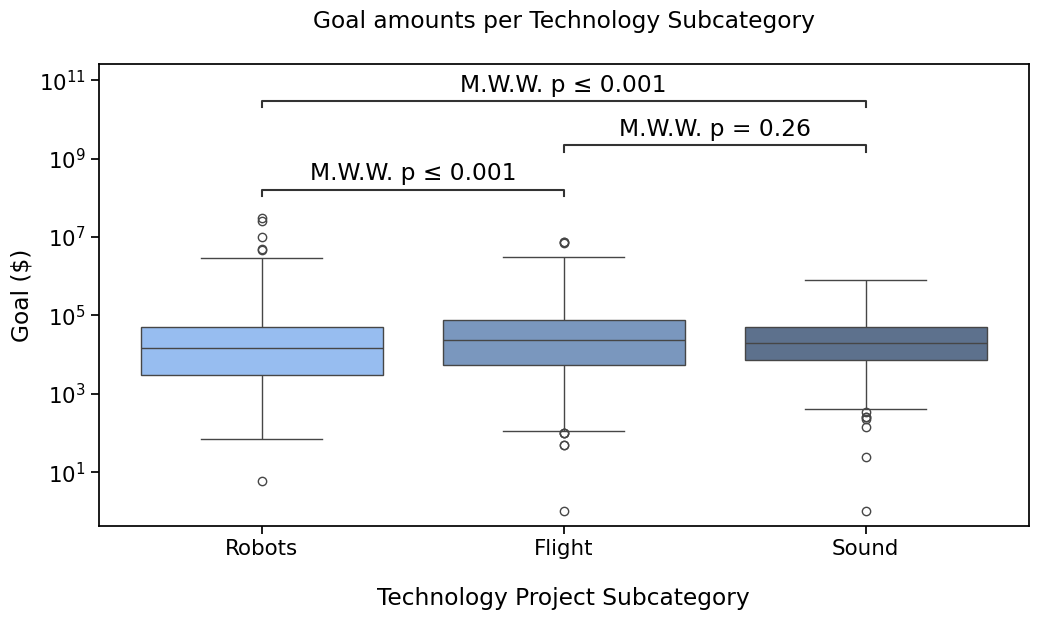

In [22]:
with sns.plotting_context('notebook', font_scale=1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    sns.boxplot(ax=ax, **plotting_parameters)

    # Add annotations
    annotator.new_plot(ax, pairs=pairs, **plotting_parameters)
    annotator.configure(test='Mann-Whitney', verbose=True).apply_and_annotate()

    # Label and show
    label_plot_for_subcats(ax)
    plt.show()

注释还有一种“完整”格式

C:\Users\ASUS\AppData\Local\Temp\ipykernel_48472\3942413743.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, **plotting_parameters)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_48472\3942413743.py:6: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.boxplot(ax=ax, **plotting_parameters)


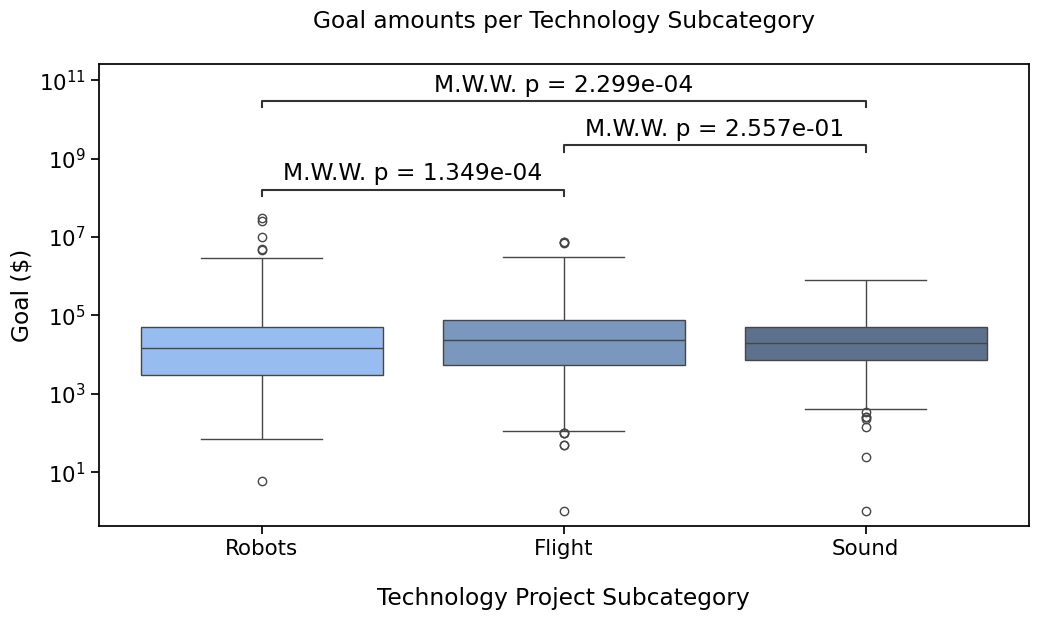

In [23]:
with sns.plotting_context("notebook", font_scale=1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    sns.boxplot(ax=ax, **plotting_parameters)

    # Add annotations
    annotator.new_plot(ax, **plotting_parameters)
    annotator.configure(text_format="full", verbose=False).apply_and_annotate()

    # Label and show
    label_plot_for_subcats(ax)
    plt.show()

###### 那么那个由`State`策划的阴谋呢？

![plot2](./plot2.png)

假设我们有兴趣比较“成功”“失败”“取消”和“进行中”这些状态。

In [24]:
values = rfs.loc[(rfs.State == "Successful"), "Goal"].values
describe_array(values, "Successful", 18)
print(normaltest(values), "\n")

log_values = np.log(rfs.loc[(rfs.State == "Successful"), "Goal"].values)
describe_array(values, "Log(Successful)", 18)
print(normaltest(log_values))

"Successful"      Number of projects: 576	Min: 1.00	Max: 8.00e+05	Avg: 31438.18	Median: 1.38e+04
NormaltestResult(statistic=np.float64(756.6903519347284), pvalue=np.float64(4.8615843204626055e-165)) 

"Log(Successful)" Number of projects: 576	Min: 1.00	Max: 8.00e+05	Avg: 31438.18	Median: 1.38e+04
NormaltestResult(statistic=np.float64(56.79986477039819), pvalue=np.float64(4.635174393791566e-13))


我们需要定义新的待比较对，然后应用相同的方法进行配置、获取测试结果并为图表添加注释。

C:\Users\ASUS\AppData\Local\Temp\ipykernel_48472\978661250.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, **state_plot_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Successful vs. Failed: Mann-Whitney-Wilcoxon test two-sided, P_val:2.813e-08 U_stat=1.962e+05
Failed vs. Live: Mann-Whitney-Wilcoxon test two-sided, P_val:2.511e-01 U_stat=9.932e+03
Successful vs. Live: Mann-Whitney-Wilcoxon test two-sided, P_val:9.215e-01 U_stat=5.971e+03
Live vs. Canceled: Mann-Whitney-Wilcoxon test two-sided, P_val:6.641e-03 U_stat=1.460e+03
Failed vs. Canceled: Mann-Whitney-Wilcoxon test two-sided, P_val:1.423e-05 U_stat=7.239e+04
Successful vs. Canceled: Mann-Whitney-Wilcoxon test two-sided, P_val:4.054e-16 U_stat=3.910e+04


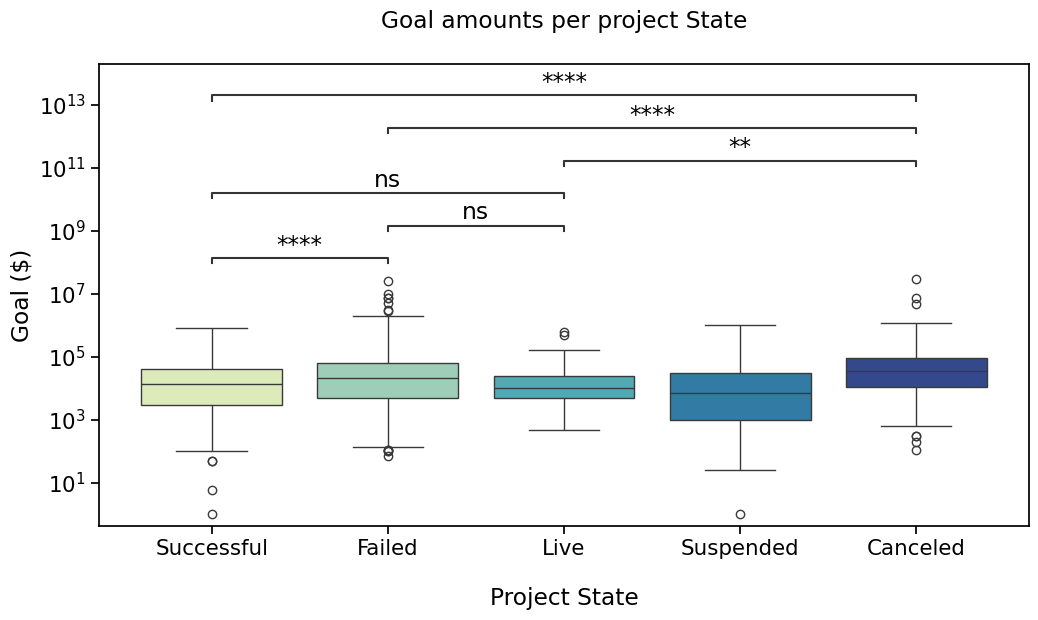

In [25]:
pairs = [
    ("Successful", "Failed"),
    ("Successful", "Live"),
    ("Failed", "Live"),
    ("Canceled", "Successful"),
    ("Canceled", "Failed"),
    ("Canceled", "Live"),
]

state_plot_params = {
    'data': rfs,
    'x': 'State',
    'y': 'Goal',
    'order': states_order,
    'palette': states_palette
}

with sns.plotting_context('notebook', font_scale=1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    sns.boxplot(ax=ax, **state_plot_params)

    # Add annotations
    annotator = Annotator(ax, pairs, **state_plot_params)
    annotator.configure(test='Mann-Whitney').apply_and_annotate()

    # Label and show
    label_plot_for_states(ax)
    plt.savefig("./plot2C.png", bbox_inches="tight")
    plt.show()

哇，这个图表真漂亮！

如果你担心多重检验和校正方法，那就继续读下去吧！

但首先，让我们看看在两级分类（带有色调的箱线图）的情况下会发生什么。

### 带色调的箱线图

我们也将处理这两组基于相同数据的图表。

#### 图3（PLOT 3）

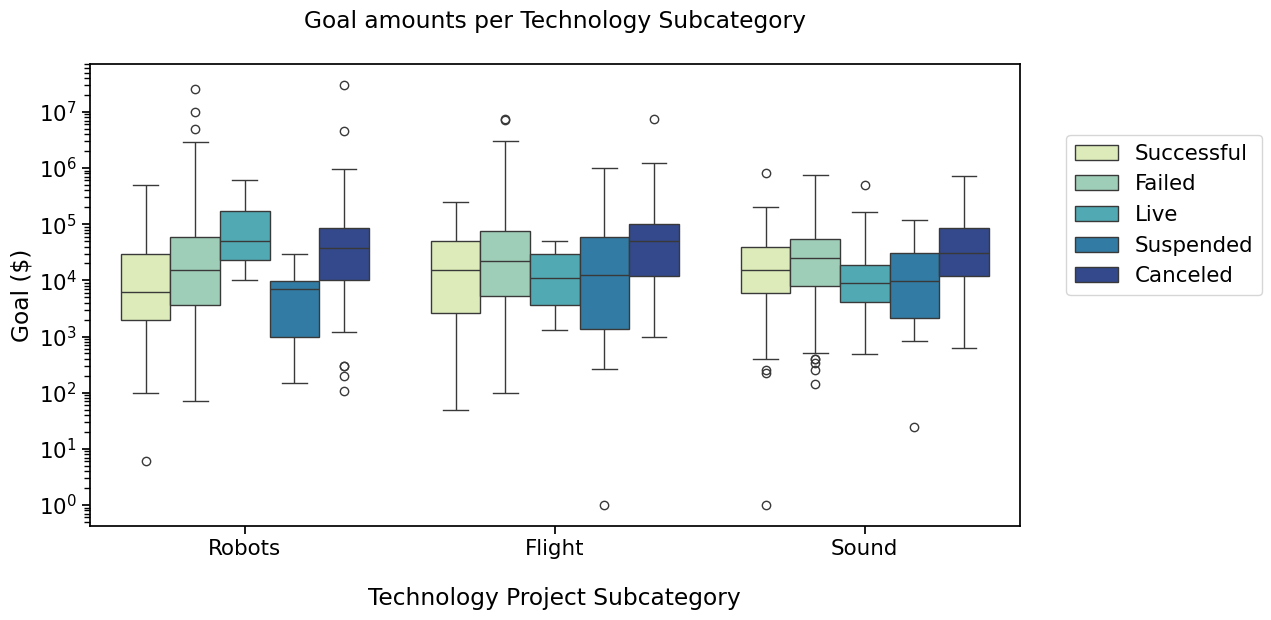

In [26]:
with sns.plotting_context('notebook', font_scale=1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    ax = sns.boxplot(ax=ax,
                     data=rfs,
                     x='Subcategory', y='Goal',
                     order=subcat_order,
                     hue="State",
                     hue_order=states_order,
                     palette=states_palette)

    # Label and show
    add_legend(ax)
    label_plot_for_subcats(ax)
    plt.show()

比较3个子类别中的“成功”“失败”和“存活”状态。

然后，箱体对必须包含关于子类别和状态的信息，其定义如下

In [24]:
pairs = [
    [('Robots', 'Successful'), ('Robots', 'Failed')],
    [('Flight', 'Successful'), ('Flight', 'Failed')],
    [('Sound', 'Successful'), ('Sound', 'Failed')],

    [('Robots', 'Successful'), ('Robots', 'Live')],
    [('Flight', 'Successful'), ('Flight', 'Live')],
    [('Sound', 'Successful'), ('Sound', 'Live')],

    [('Robots', 'Failed'), ('Robots', 'Live')],
    [('Flight', 'Failed'), ('Flight', 'Live')],
    [('Sound', 'Failed'), ('Sound', 'Live')],
]

同样，将绘图参数放入字典中，这样我们就可以使用它两次，然后再使用Annotator（标注工具）

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Sound_Failed vs. Sound_Live: Mann-Whitney-Wilcoxon test two-sided, P_val:5.311e-02 U_stat=2.534e+03
Robots_Successful vs. Robots_Failed: Mann-Whitney-Wilcoxon test two-sided, P_val:1.435e-04 U_stat=2.447e+04
Robots_Failed vs. Robots_Live: Mann-Whitney-Wilcoxon test two-sided, P_val:2.393e-01 U_stat=2.445e+02
Flight_Successful vs. Flight_Failed: Mann-Whitney-Wilcoxon test two-sided, P_val:4.658e-02 U_stat=8.990e+03
Flight_Failed vs. Flight_Live: Mann-Whitney-Wilcoxon test two-sided, P_val:4.185e-01 U_stat=6.875e+02
Sound_Successful vs. Sound_Failed: Mann-Whitney-Wilcoxon test two-sided, P_val:1.222e-03 U_stat=3.191e+04
Robots_Successful vs. Robots_Live: Mann-Whitney-Wilcoxon test two-sided, P_val:8.216e-02 U_stat=1.405e+02
Flight_Successful vs. Flight_Live: Mann-Whitney-Wilcoxon test two-sided, P_val:7.825e-0

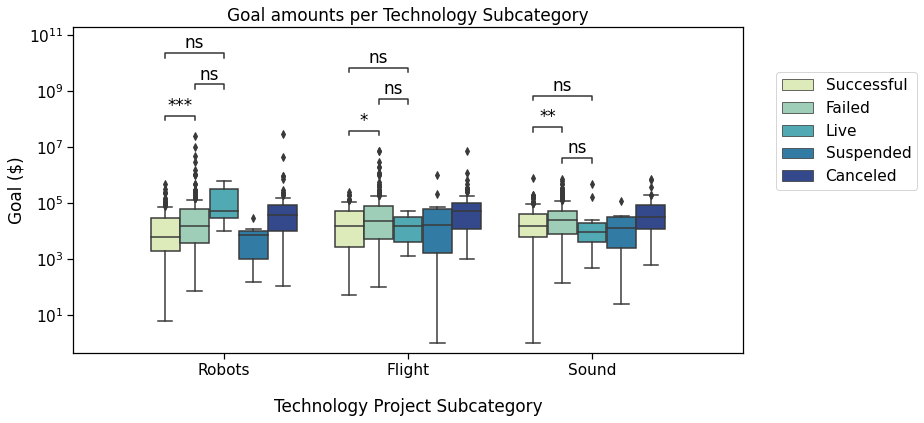

In [25]:
hue_plot_params = {
    'data': rfs,
    'x': 'Subcategory',
    'y': 'Goal',
    "order": subcat_order,
    "hue": "State",
    "hue_order": states_order,
    "palette": states_palette
}

with sns.plotting_context("notebook", font_scale=1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    ax = sns.boxplot(ax=ax, **hue_plot_params)

    # Add annotations
    annotator = Annotator(ax, pairs, **hue_plot_params)
    annotator.configure(test="Mann-Whitney").apply_and_annotate()

    # Label and show
    add_legend(ax)
    label_plot_for_subcats(ax)
    plt.show()

#### 图4（PLOT 4）

为了跨类别比较这些状态，让我们换一种方式来绘制图表。

C:\Users\ASUS\AppData\Local\Temp\ipykernel_48472\377511206.py:17: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  ax = sns.boxplot(ax=ax, **hue_plot_params)


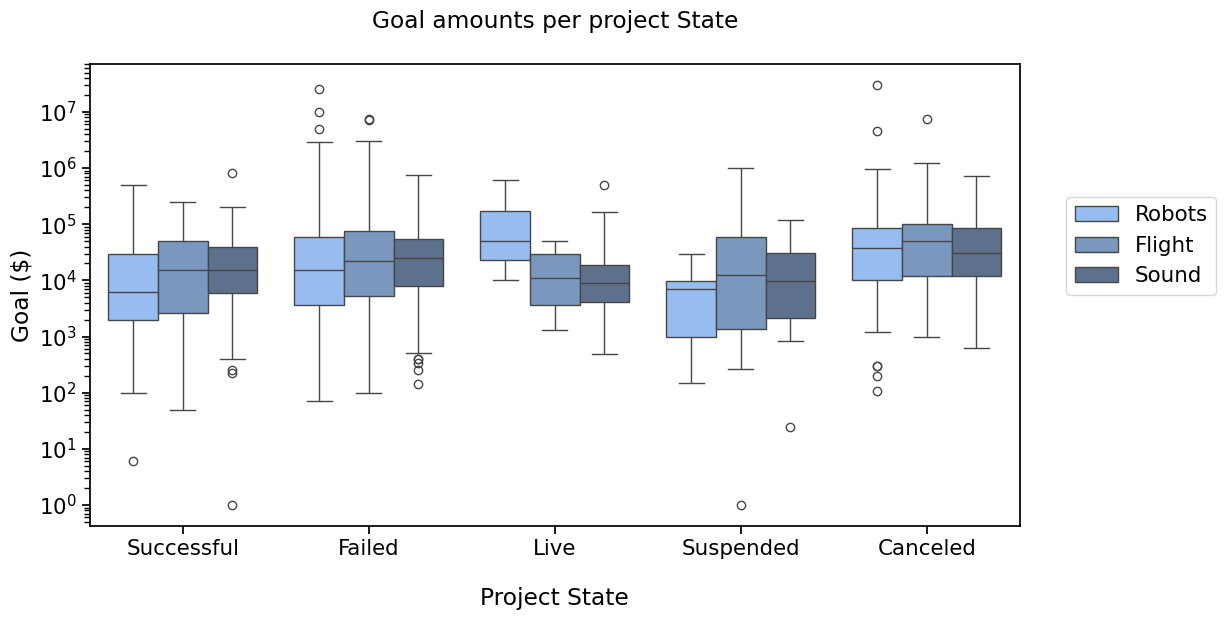

In [27]:
# Switching hue and x
hue_plot_params = {
    'data':      rfs,
    'x':         'State',
    'y':         'Goal',
    "order":     states_order,
    "hue":       "Subcategory",
    "hue_order": subcat_order,
    "palette":   subcat_palette
}

with sns.plotting_context("notebook", font_scale=1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    ax = sns.boxplot(ax=ax, **hue_plot_params)

    # Label and show
    add_legend(ax)
    label_plot_for_states(ax)
    plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_48472\1788428573.py:20: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  ax = sns.boxplot(ax=ax, **hue_plot_params)


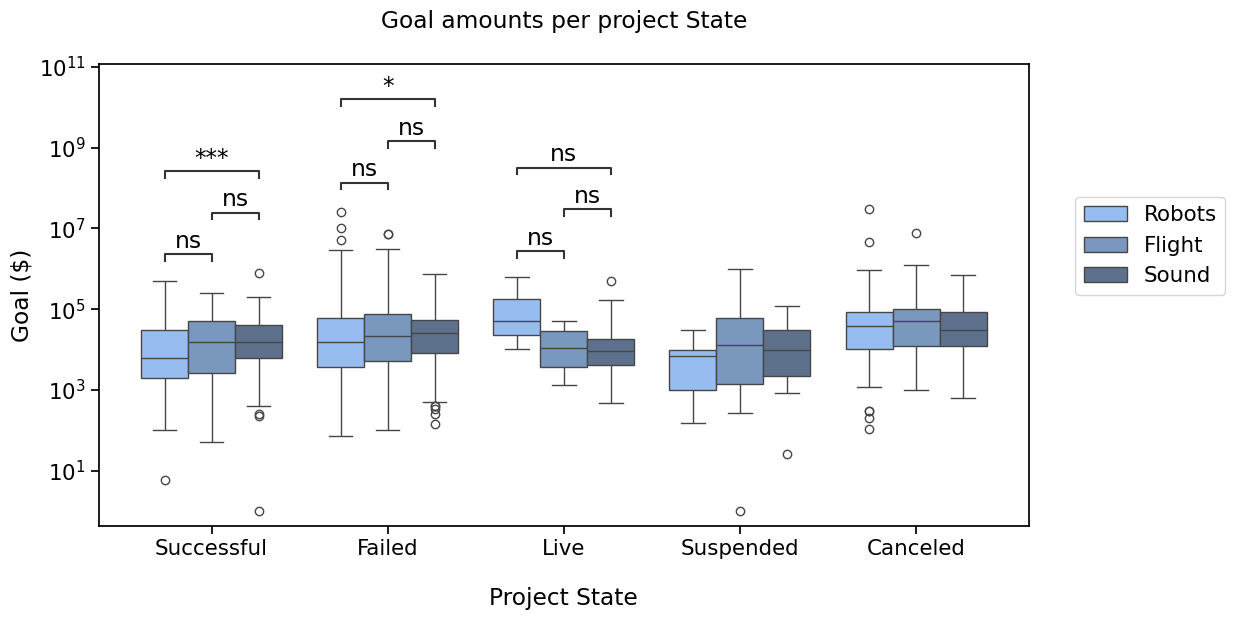

In [28]:
pairs =(
    [('Successful', 'Robots'), ('Successful', 'Flight')],
    [('Successful', 'Flight'), ('Successful', 'Sound')],
    [('Successful', 'Robots'), ('Successful', 'Sound')],

    [('Failed', 'Robots'), ('Failed', 'Flight')],
    [('Failed', 'Flight'), ('Failed', 'Sound')],
    [('Failed', 'Robots'), ('Failed', 'Sound')],

    [('Live', 'Robots'), ('Live', 'Flight')],
    [('Live', 'Flight'), ('Live', 'Sound')],
    [('Live', 'Robots'), ('Live', 'Sound')],
)

with sns.plotting_context("notebook", font_scale=1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    ax = sns.boxplot(ax=ax, **hue_plot_params)

    # Add annotations
    annotator = Annotator(ax, pairs, **hue_plot_params)
    annotator.configure(test="Mann-Whitney", verbose=False)
    _, results = annotator.apply_and_annotate()

    # Label and show
    add_legend(ax)
    label_plot_for_states(ax)
    plt.show()

然而，需要注意的是，这仍然涉及大量检验。若需采用多重检验校正方法，该操作具备可行性。

#### 多重检验校正（简介）

在本节中，我将快速演示如何使用一个现成的接口。更高级的用法将在后续教程中介绍。

通常，您可以为 `.configure` 方法使用 `comparisons_correction` 参数，以选择以下校正方法之一（这些方法由 `statsmodels` 实现）：
- 邦费罗尼校正（Bonferroni，参数值为 "bonf"）
- 本杰明尼-霍赫伯格校正（Benjamini-Hochberg，参数值为 "BH"）
- 霍尔姆-邦费罗尼校正（Holm-Bonferroni，参数值为 "HB"）
- 本杰明尼-耶库蒂利校正（Benjamini-Yekutieli，参数值为 "BY"）

C:\Users\ASUS\AppData\Local\Temp\ipykernel_48472\817599535.py:6: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  ax = sns.boxplot(ax=ax, **hue_plot_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Failed_Robots vs. Failed_Flight: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:8.298e-01 U_stat=3.441e+04
Failed_Flight vs. Failed_Sound: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=3.803e+04
Live_Robots vs. Live_Flight: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=9.500e+00
Live_Flight vs. Live_Sound: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=2.900e+01
Successful_Robots vs. Successful_Flight: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:8.862e-01 U_stat=7.500e+03
Successful_Flight vs. Successful_Sound: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=1.013e+04
Failed_Robots vs.

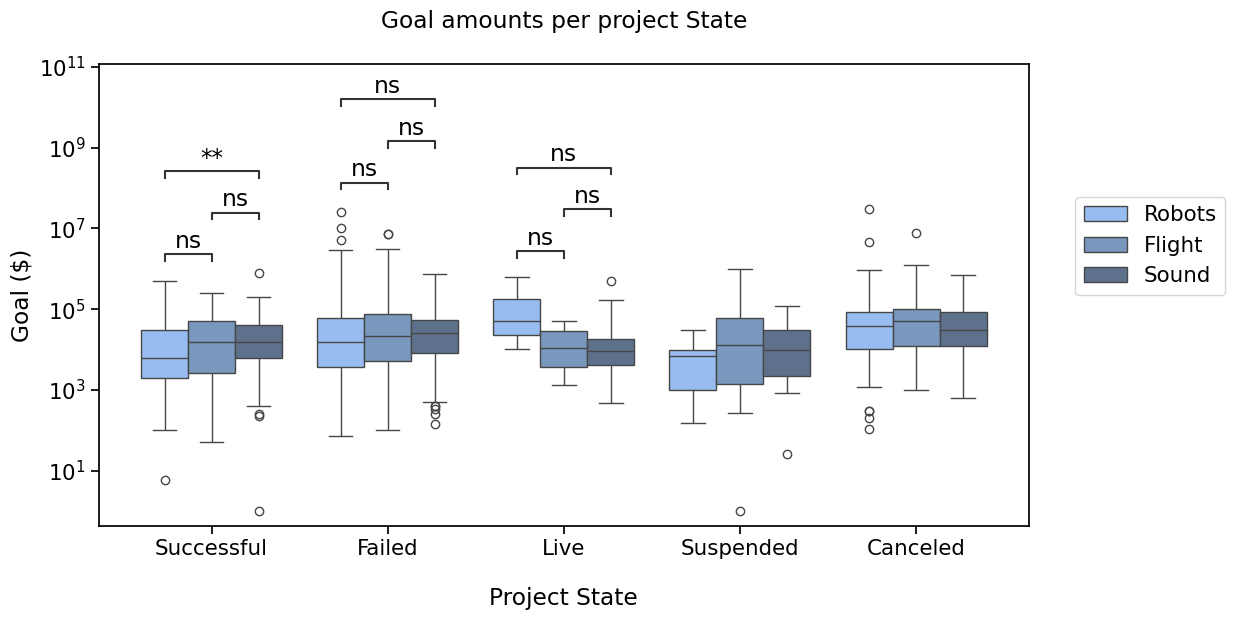

In [29]:
with sns.plotting_context("notebook", font_scale=1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    ax = sns.boxplot(ax=ax, **hue_plot_params)

    # Add annotations
    annotator = Annotator(ax, pairs, **hue_plot_params)
    annotator.configure(test="Mann-Whitney", comparisons_correction="bonferroni")
    _, corrected_results = annotator.apply_and_annotate()

    # Label and show
    add_legend(ax)
    label_plot_for_states(ax)
    plt.show()

在这种情况下，这并没有改变结论，但如你所见，p值已经过校正。

In [30]:
for result, corrected_result in zip(results, corrected_results):
    print(f"{result.data.pvalue:.2e} => {corrected_result.data.pvalue:.2e}")

9.22e-02 => 8.30e-01
8.04e-01 => 1.00e+00
2.85e-01 => 1.00e+00
9.59e-01 => 1.00e+00
9.85e-02 => 8.86e-01
7.23e-01 => 1.00e+00
4.19e-02 => 3.77e-01
1.21e-01 => 1.00e+00
1.67e-04 => 1.50e-03


因此，“失败”（`Failed`）、“机器人”（`Robots`）和“声音”（`Sound`）类项目在目标金额上的差异，从约`0.04`变化至约`0.4`（即前一列表中的倒数第二项）；并且在默认显著性水平`α = 0.05`的情况下，该差异不再被认为具有统计学意义。



## Bonus

本工具支持其他类型的图表。以下为使用`barplot`（条形图）绘制的相同图表，且附带了其他经过调整的参数。

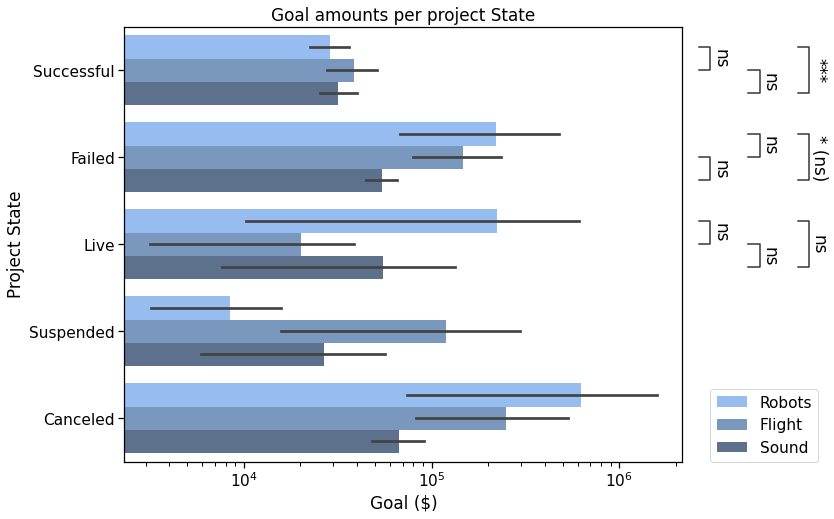

In [30]:
hue_plot_params = {**hue_plot_params, 'x':  'Goal','y': 'State','dodge': True, 'orient': 'h'}

with sns.plotting_context("notebook", font_scale=1.4):
    # Create new plot
    ax = get_log_ax('h')

    # Plot with seaborn
    ax = sns.barplot(ax=ax, **hue_plot_params)

    # Add annotations
    annotator = Annotator(ax, pairs, plot='barplot', **hue_plot_params)
    annotator.configure(test="Mann-Whitney", comparisons_correction="BH",
                        verbose=False, loc="outside").apply_and_annotate()

    # Label and show
    ax.set_xlabel("Goal ($)")
    ax.set_ylabel("Project State")
    plt.title("Goal amounts per project State")
    ax.legend(loc=(1.05, 0))
    plt.show()

## 结论

恭喜您完成本教程的学习。在本文中，我们介绍了`Annotator`的多种应用场景，涵盖从使用自定义标签（custom labels）到通过该包执行统计检验（statistical tests）的各类情况，且所有场景均提供了多种格式设置选项（formatting options）。

目前介绍的内容已能覆盖诸多应用场景，但您也可期待后续部分，以了解更多功能。

### 接下来是什么？

在后续教程中，我们将介绍如何实现以下操作：
- 为不同类型的图表添加标注（Annotate different kinds of plots）
- 使用该库中尚未提供的其他函数进行统计检验（statistical tests）与多重比较校正（multiple comparisons correction），且仅需编写极少的额外代码（minimal extra code）
- 在标注文本格式（text_format）选项内进一步自定义p值格式（Further customize the p-values format）
- 调整标注之间的间距（Adjust the spacing between annotations），或在绘图区域外定位标注（position them outside the plotting area）
- 使用其他输出结果（Use the other outputs）

### 致谢

`Statannotations` 自早期阶段起便是一项协作性工作（collaborative work）。在两年前我首次为其贡献代码之前，[statannot](https://github.com/webermarcolivier/statannot) 包已完成了大量开发工作，能成为该项目的一份子，我感到非常欣慰（very gratifying）。

[Jupyter to Medium](https://github.com/dexplo/jupyter_to_medium) 与 [Junix](https://github.com/damienmarlier51/JupyterNotebookImageExporter) 这两个包是极具价值的资源（helpful resources），它们有效减轻了将 Notebook 转换为文章（turning the notebook into an article）的工作负担（reduce the load）。若您有导出 Notebook 的需求，建议您尝试使用这两个工具（check them out）。